# GreatApeT2T-G4s `notebook#2`
This jupyter notebook contains code snippets to generate:
 1. KDE plot for the pqsfinder and G4Hunter inflections runs.
 2. Plots for the number of pG4s in the newly resolved regions of T2T genomes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

## 1. To read and generate plots for inferring inflection points for pqsfinder and G4Hunter

In [2]:
''' Read the bedfile with G4s predicted with a pqsfinder score >= 30, and an absolute hunter score >= 0 '''

df = pd.read_csv('../datasets/pG4s/Homo_sapiens/inflectionTest/chrG.pqsfinder.filtered.pqsfinderGT30.ABShunterGT0.bed.gz', header=None, sep='\t', compression='gzip')
df.columns = ['chr','start','end','pqsfinderScore','length','strand','G4HunterScore']
df = df[df['pqsfinderScore'] < 150] # to remove "rare" outliers
df

,chr,start,end,pqsfinderScore,length,strand,G4HunterScore
0,chr1,16,37,64.0,21,-,-1.71
1,chr1,60,81,64.0,21,-,-1.71
2,chr1,84,105,64.0,21,-,-1.71
3,chr1,108,129,64.0,21,-,-1.71
4,chr1,132,153,64.0,21,-,-1.71
...,...,...,...,...,...,...,...
1151481,chrY,62459896,62459917,64.0,21,+,1.71
1151482,chrY,62459920,62459941,64.0,21,+,1.71
1151483,chrY,62459944,62459965,64.0,21,+,1.71
1151484,chrY,62459968,62459989,64.0,21,+,1.71


In [3]:
bw_thresh = 1

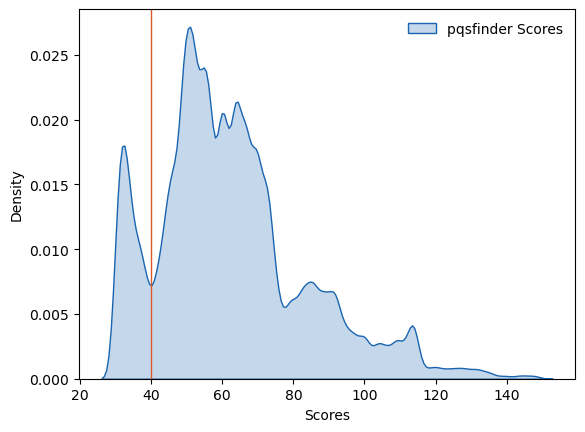

In [4]:
''' Generate the distribution plot for pqsfinder '''

sns.kdeplot(df['pqsfinderScore'], bw_adjust=bw_thresh, fill=True, label='pqsfinder Scores', color='#1964b0')

plt.xlabel("Scores")
plt.ylabel("Density")
plt.legend(frameon=False)
plt.axvline(x=40, color='#db5829', linestyle='-', alpha=1, linewidth=1)
plt.savefig('../plots/inflectionTestPlots/pqsfinder.png', dpi=300, bbox_inches='tight')
plt.show()

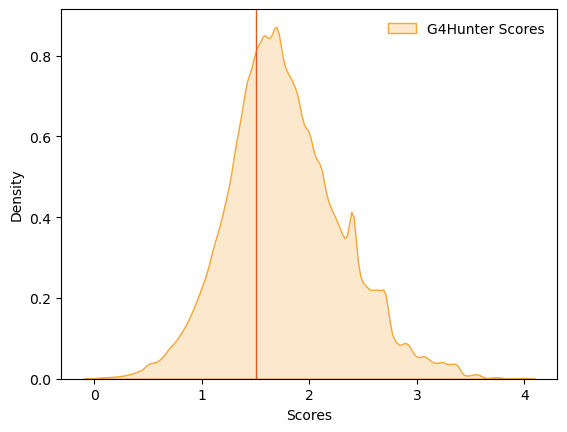

In [5]:
''' Generate the distribution plot for G4Hunter '''

sns.kdeplot(np.abs(df['G4HunterScore']), bw_adjust=bw_thresh, fill=True, label='G4Hunter Scores', color="#f4a637")

plt.xlabel("Scores")
plt.ylabel("Density")
plt.legend(frameon=False)
plt.axvline(x=1.5, color='#db5829', linestyle='-', alpha=1, linewidth=1)
plt.savefig('../plots/inflectionTestPlots/g4hunter.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. To generate plots for the number of pG4s in the newly resolved T2T regions

In [6]:
chrLen = pd.read_csv('../datasets/dataForAnalysis/genomeLength/totalGenomeLength.dat', sep='\t', header=0, index_col=0)
chrLen.columns = ["human", "bonobo", "chimpanzee", "gorilla", "s. orangutan", "b. orangutan"]

totalG4s = {'bonobo': 798523, 
            'chimpanzee': 789030, 
            'human': 769188,
            'gorilla': 844654, 
            's. orangutan': 791208, 
            'b. orangutan': 785090}

#### New pG4s in human T2T vs hg38

Adapted from the bed file (`chm13v2-unique_to_hg38.bed`) present 
at [https://github.com/marbl/CHM13?tab=readme-ov-file](https://github.com/marbl/CHM13?tab=readme-ov-file)

In [7]:
species = {"Homo_sapiens": "human"}

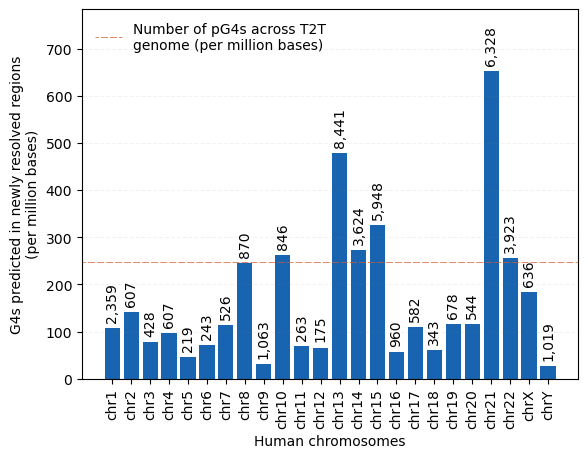

In [8]:
for spec in species:
    newG4s = pd.read_csv(f'../datasets/dataForAnalysis/newT2Tregions/{spec}/newG4sinnewRegions.dat', header=None, sep='\t')
    newG4s.columns = ['chr', 'newG4s']
    
    newRegions = pd.read_csv(f'../datasets/dataForAnalysis/newT2Tregions/{spec}/newRegions.dat', header=None, sep='\t')
    newRegions.columns = ['chr', 'newRegionsTotal']

    # print(newG4s['newG4s'].sum()) # get the number of G4s in newly resolved regions
    ratio = newG4s['newG4s'] / newRegions['newRegionsTotal'] * 1e6

    ax = plt.bar(range(24), ratio, color="#1964b0")

    plt.axhline(y=totalG4s[species[spec]] / chrLen.loc["Total",species[spec]]*1e6, color='#db5829', linestyle=(5, (10, 3)), label='Number of pG4s across T2T\ngenome (per million bases)', linewidth=0.5)
    plt.ylabel("G4s predicted in newly resolved regions\n(per million bases)")
    plt.xlabel(f"{species[spec].capitalize()} chromosomes")
    plt.grid(linestyle='--', color='gray', alpha=0.1, axis='y')
    plt.legend(frameon=False, loc='upper left')
    plt.ylim([0, max(ratio)*1.2])
    
    for i in range(24):
        plt.text(i,ratio[i]+max(ratio)/35,f'{newG4s["newG4s"][i]:,}',rotation=90, ha="center")

    plt.xticks(range(24), ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 
                           'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY'], rotation=90)

    plt.savefig(f'../plots/G4sOverlapNewT2TregionPlots/{species[spec]}_newRegions_G4s.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'../plots/G4sOverlapNewT2TregionPlots/{species[spec]}_newRegions_G4s.svg', format='svg', transparent=True, bbox_inches='tight')
    plt.show()

#### pG4 proportion in repeats classified as new (in T2T-resolved regions) and old

In [9]:
# load all the new (in T2T-resolved regions) and old G4s in human
newG4s = pd.read_csv(f'../datasets/dataForAnalysis//newT2Tregions/{spec}/g4s_inNewRegionsT2T.bed', header=None, sep='\t')
newG4s = newG4s.iloc[:, :7]
oldG4s = pd.read_csv(f'../datasets/dataForAnalysis//newT2Tregions/{spec}/g4s_inOldRegionsT2T.bed', header=None, sep='\t')
columns = ['chr','start','end','pqsscore','len','starnd','hunterscore']
newG4s.columns = columns
newG4s['label'] = 'NEW'
oldG4s.columns = columns
oldG4s['label'] = 'OLD'

# load all the new (in T2T-resolved regions) and old G4s in human that donot intersect with repeats
newG4s_NOTinrepeats = pd.read_csv(f'../datasets/dataForAnalysis/newT2Tregions/{spec}/g4s_inNewregions_NOTinRepeats.bed', header=None, sep='\t')
newG4s_NOTinrepeats = newG4s_NOTinrepeats.iloc[:, :7]
oldG4s_NOTinrepeats = pd.read_csv(f'../datasets/dataForAnalysis/newT2Tregions/{spec}/g4s_inOldregions_NOTinRepeats.bed', header=None, sep='\t')
columns = ['chr','start','end','pqsscore','len','starnd','hunterscore']
newG4s_NOTinrepeats.columns = columns
oldG4s_NOTinrepeats.columns = columns
newG4s_NOTinrepeats['label'] = 'NEW'
oldG4s_NOTinrepeats['label'] = 'OLD'

# make a dataframe to plot proportion of G4s in T2T-resolved regions and previously resolved regions
data = {'newG4s_NOTinrepeats':[], 'newG4s':[], 'oldG4s_NOTinrepeats':[], 'oldG4s':[]}
chromosomes = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y']]
for chr in chromosomes:
    for key, val in data.items():
        data_df = eval(key)
        num = len(data_df[data_df['chr']==f'{chr}'])
        data[key].append(num)
data.update({'chr':chromosomes})
data = pd.DataFrame.from_dict(data)

data['newG4sprop_inRepeats'] = 100 - data['newG4s_NOTinrepeats']/data['newG4s']*100
data['oldG4sprop_inRepeats'] = 100 - data['oldG4s_NOTinrepeats']/data['oldG4s']*100
data['G4s in T2T-resolved regions'] = data['newG4sprop_inRepeats']
data['G4s in previously resolved regions'] = data['oldG4sprop_inRepeats']

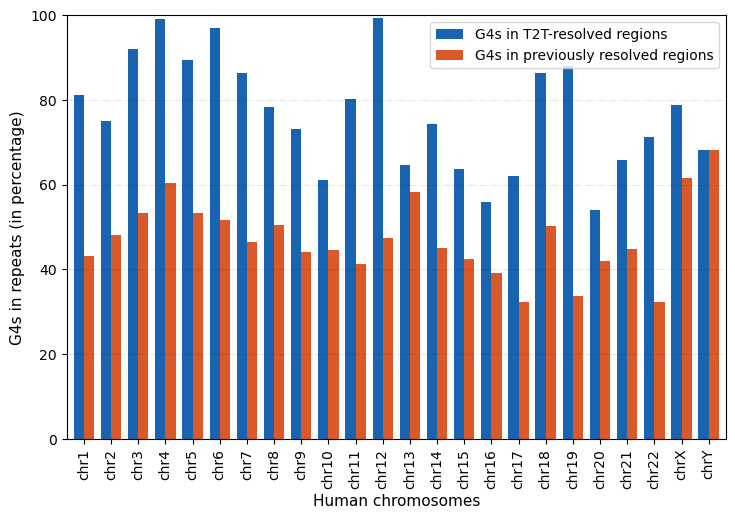

In [10]:
# plot the proportion of G4s in T2T-resolved regions and previously resolved regions
data.iloc[:, 7:9].plot.bar(rot=0, width=0.75, figsize=(8.5, 5.5), fontsize=10, color=['#1964b0', '#db5829'])

plt.xticks(range(0,24),list(data['chr'].unique()),rotation=90)
plt.ylabel("G4s in repeats (in percentage)", fontsize=11)
plt.xlabel("Human chromosomes", fontsize=11)
plt.legend(fontsize=10)
plt.ylim([0, 100])
plt.grid(axis='y',color='black', alpha=0.1, linestyle='-.')

plt.savefig(f'../plots/G4sOverlapNewT2TregionPlots/{species[spec]}_G4s_inRepeats.png', dpi=300, bbox_inches='tight')
plt.savefig(f'../plots/G4sOverlapNewT2TregionPlots/{species[spec]}_G4s_inRepeats.svg', format='svg', transparent=True, bbox_inches='tight')

plt.show()

#### New pG4s in non-human great ape T2T genomes

**The previous assemblies for all the non-human great apes are listed as follows**  
panTro6, gorGor6, panPan3, ponAbe3 and hg38.  
And for the Y chromosomes its the Makova lab's Y releases.

`wget https://hgdownload.soe.ucsc.edu/goldenPath/panTro6/bigZips/panTro6.fa.gz`  
`wget https://hgdownload2.soe.ucsc.edu/goldenPath/gorGor6/bigZips/gorGor6.fa.gz`  
`wget https://hgdownload2.soe.ucsc.edu/goldenPath/panPan3/bigZips/panPan3.fa.gz`  
`wget https://hgdownload.soe.ucsc.edu/goldenPath/ponAbe3/bigZips/ponAbe3.fa.gz`  
`wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/015/021/865/GCA_015021865.1_gorGor.msY.makovalab.ver3/GCA_015021865.1_gorGor.msY.makovalab.ver3_genomic.fna.gz`  
`wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/015/021/855/GCA_015021855.1_panPan.msY.makovalab.ver1/GCA_015021855.1_panPan.msY.makovalab.ver1_genomic.fna.gz`  
`wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/015/021/835/GCA_015021835.1_ponAbe.msY.makovalab.ver3/GCA_015021835.1_ponAbe.msY.makovalab.ver3_genomic.fna.gz`

In [11]:
species = {"Pan_paniscus": "bonobo", "Pan_troglodytes": "chimpanzee", "Gorilla_gorilla": "gorilla", "Pongo_abelii": "s. orangutan"}

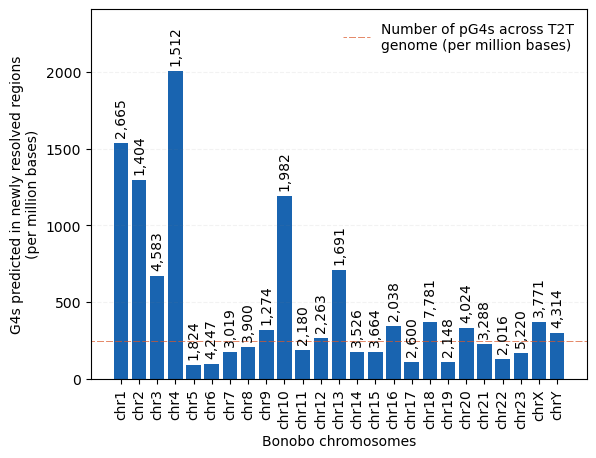

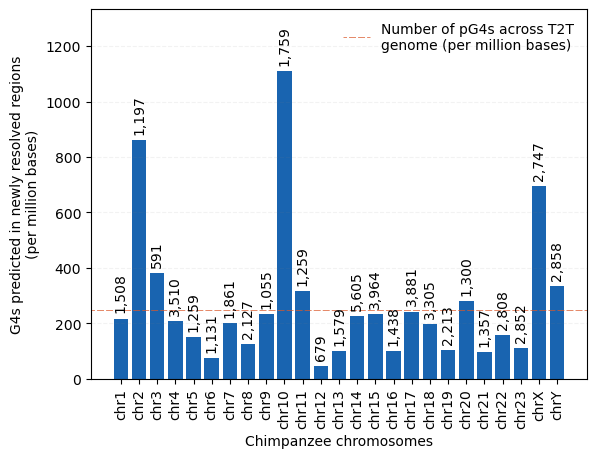

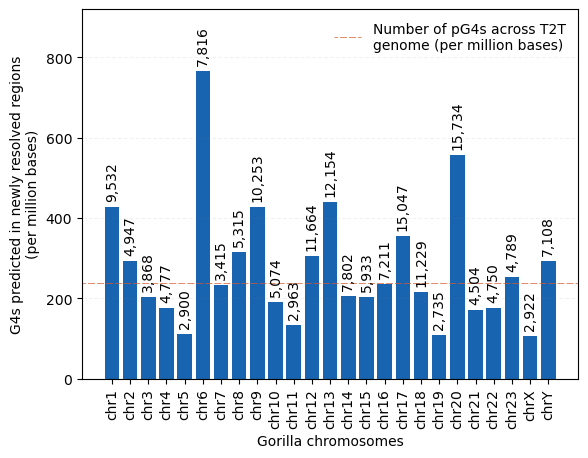

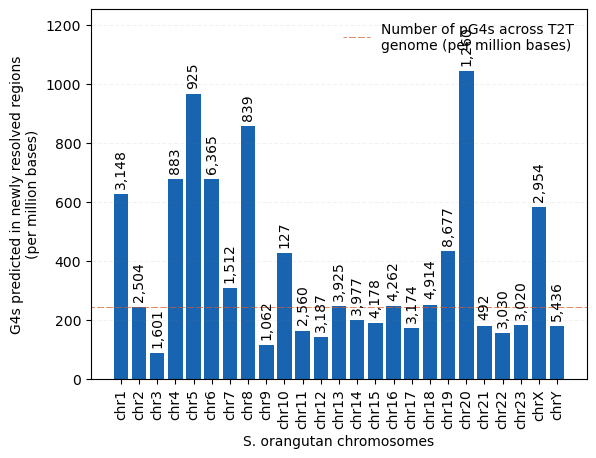

In [12]:
for spec in species:
    newG4s = pd.read_csv(f'../datasets/dataForAnalysis/newT2Tregions/{spec}/newG4sinnewRegions.dat', header=None, sep='\t')
    newG4s.columns = ['chr', 'newG4s']
    
    newRegions = pd.read_csv(f'../datasets/dataForAnalysis/newT2Tregions/{spec}/newRegions.dat', header=None, sep='\t')
    newRegions.columns = ['chr', 'newRegionsTotal']

    # print(newG4s['newG4s'].sum()) # get the number of G4s in newly resolved regions
    ratio = newG4s['newG4s'] / newRegions['newRegionsTotal'] * 1e6

    ax = plt.bar(range(25), ratio, color="#1964b0")

    plt.axhline(y=totalG4s[species[spec]] / chrLen.loc["Total",species[spec]]*1e6, color='#db5829', linestyle=(5, (10, 3)), label='Number of pG4s across T2T\ngenome (per million bases)', linewidth=0.5)
    plt.ylabel("G4s predicted in newly resolved regions\n(per million bases)")
    plt.xlabel(f"{species[spec].capitalize()} chromosomes")
    plt.grid(linestyle='--', color='gray', alpha=0.1, axis='y')
    plt.legend(frameon=False)
    plt.ylim([0, max(ratio)*1.2])
    
    for i in range(25):
        plt.text(i,ratio[i]+max(ratio)/35,f'{newG4s["newG4s"][i]:,}',rotation=90, ha="center")

    plt.xticks(range(25), ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 
                           'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chr23', 'chrX', 'chrY'], rotation=90)

    plt.savefig(f'../plots/G4sOverlapNewT2TregionPlots/{species[spec]}_newRegions_G4s.png', dpi=300, bbox_inches='tight')
    plt.show()